### Imports and settings for this notebook

In [1]:
# general notebook formatting for markdown and plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings

import matplotlib.pyplot as plt

# level of warning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML

In [2]:
# imports for code examples
import os

from pygromos.files.gromos_system.gromos_system import Gromos_System
from pygromos.files.gromos_system.ff.forcefield_system import forcefield_system
from pygromos.files.simulation_parameters.imd import Imd

from pygromos.simulations.modules.preset_simulation_modules import sd
from pygromos.simulations.modules.preset_simulation_modules import emin
from pygromos.data.simulation_parameters_templates import template_sd, template_emin_vac

# PyGromosToolsDay

## Introduction

This notebook is created for the PyGromosToolsDay on 17.02.2022    
Author: Marc Thierry Lehner  

This notebook is part of the package `PyGromosTools` and can be found under:

https://github.com/rinikerlab/PyGromosTools/blob/pygromosDay/examples/PyGromosToolsDay/pyGromosToolsDay.ipynb

### Schedule for the day
<a id='schedule'></a>

1. Introduction (start 09:00)
  - Welcoming
  - [Schedule for the day](#schedule)
2. Overview over current state  
  - [PyGromosTools - a Python package for `GROMOS` users](#PyGromosTools-a-Python-package-for-GROMOS-users)  
    1. [General File Structure](#file_structure)
    2. [Simple Simulation](#simple-simulation)
    3. [Simple Analysis](#simple-analysis)
    4. [Non-standard blocks and simple modifications](#non-standard-blocks-and-simple-modifications)
    5. [New files for new gromos functionality](#new-files-for-new-gromos-functionality)
3. Discussion of intended new features and current bugs
  - [Release 3](#release-3)
    1. [New features](#new-features)
    2. [Current bugs](#current-bugs)
4. Hackathon (on the discussed topics) (start ~11:00)
5. Closing assembly and discussion of progress towards next release (start 16:30)


## PyGromosTools - a Python package for `GROMOS` users

`PyGromosTools` is a Python package for `GROMOS` users. It tries to provide an easy to use and unified interface to `GROMOS` in Python. Users of `PyGromosTools` profit from better readability and reproducibility of code, as well as easier pipelining of `GROMOS` simulations.

`PyGromosTools` is a naturally grown package, which tries to adhere to the needs of all `GROMOS` users.

At the current state `PyGromosTools` provides:

1. gromosXX wrappers
2. gromos++ wrappers
3. File handling of all `GROMOS` file types for automated creation, modification, and analysis
4. Automation and file management system: the central class `gromos_system`
5. Simulation submission and execution
6. etc.

In the following sections, we will see how to use `PyGromosTools` to automate the creation of typical `GROMOS` simulations and how these tools are intended to be used. We will show simple usecases and provide ways to adjust existing classes to accomodate for more complex simulations or new blocks. Finally, we show how you can contribute to `PyGromosTools`. And how to extend `PyGromosTools` to your own needs.

### General File Structure
<a id='file_structure'></a>

Since the second major release (TODO: date???) `PyGromosTools` is focused around a class called `gromos_system`. This class is the main entry point of `PyGromosTools` and is used to create, manage and analyse `GROMOS` simulations.  

`gromos_system` stores information of all files regarding a simulation and provides methods to create, modify and analyse these files.


<p style="text-align:center;">
    <img src="./figures/gromos_system_overview.png" width=900 alt="gromos_system_overview"/>
    <div style="text-align:center;">Based on B. Ries Thesis</div>
</p> 

`gromos_system` can be initialized in many different ways. The simplest is from existing files. However, there is also the option to create a `gromos_system` object from only a `SMILES` string and a forcefield. Having said that, it has to be mentioned, that for all `GROMOS`-type forcefields the correct `MTB` name is required as well (for now).  

In the following example, we first first a `forcefield_system` object that holds all informations regarding the forcefield used. This `forcefield_system` object is then used to create a `gromos_system` from a `SMILES` string.   

If the options `adapt_imd_automatically` and `auto_convert` are activated in `gromos_system`, we will not only automatically create  the system topology but also the coordinate file and an adjusted `IMD` file.

In [3]:
work_dir = os.path.abspath("./example_sys/")

In [4]:
ff = forcefield_system(name="2016H66")
ff.mol_name = "BZN"

In [5]:
# create the Gromos_System object
# paths to Gromos binaries can be provided
groSys = Gromos_System(work_folder=work_dir,
                system_name="test_system",
                in_smiles="c1ccccc1", 
                #in_gromosPP_bin_dir="/home/fpultar/bin/gromos++/bin",
                #in_gromosXX_bin_dir="/home/fpultar/bin/gromosXX/bin",
                Forcefield=ff, 
                adapt_imd_automatically=True,
                in_imd_path=template_emin_vac, 
                auto_convert=True)

This `gromos_system` object called `groSys` now contains topology, coordinate, and input files for benzene, all created automatically! 

We can access all these files as Python classes by via the `groSys.top`, `groSys.cnf` and `groSys.imd` attributes.  
All these classe are instances of the `gromos_file` class and have attributes on their own, which are the associated `GROMOS` blocks (and of course sometimes additional content).  

For example, we can check if the new topology has a correct TITLE block by accessing the attribute `groSys.top.TITLE`. And we can see, the title block was automatically generated.

In [6]:
#help(groSys.top.TITLE)

In [7]:
groSys.top.TITLE

TITLE
MAKE_TOP topology, using:
/home/mlehner/PyGromosTools/pygromos/data/ff/Gromos2016H66/2016H66.mtb
/home/mlehner/PyGromosTools/pygromos/data/ff/Gromos2016H66/2016H66_orga.mtb
/home/mlehner/PyGromosTools/pygromos/data/ff/Gromos2016H66/2016H66.ifp

Force-field code: 2016H66

	>>> Generated with PyGromosTools (riniker group) <<<
END

The same is also true for the other files. It's worth to mention that the coordinate file is generated automatically using the `RDKit` conformer generator under the hood.

In [8]:
groSys.cnf.POSITION

POSITION
# 	 
    1 BZN   C1         1    0.080600000   -0.114300000    0.001500000
    1 BZN   H1         2    0.143435194   -0.203358253    0.002668736
    1 BZN   C2         3    0.139300000    0.012700000   -0.000200000
    1 BZN   H2         4    0.247852856    0.022561710   -0.000355389
    1 BZN   C3         5    0.058700000    0.127000000   -0.001700000
    1 BZN   H3         6    0.104422350    0.225937924   -0.003024364
    1 BZN   C4         7   -0.080600000    0.114300000   -0.001500000
    1 BZN   H4         8   -0.143435194    0.203358253   -0.002668736
    1 BZN   C5         9   -0.139300000   -0.012700000    0.000200000
    1 BZN   H5        10   -0.247852856   -0.022561710    0.000355389
    1 BZN   C6        11   -0.058700000   -0.127000000    0.001700000
    1 BZN   H6        12   -0.104422350   -0.225937924    0.003024364
END

All these blocks contain classes for the specific fields. In the case of the `POSITION` block, we have a list of atoms. For each atom, name, type, and position are stored. This makes it easy to make adjustments, search for specific atoms or do some general scripted modifiactions to the positions.

<p style="text-align:center;">
    <img src="./figures/gromos_file.png" height=300 alt="gromos file structure"/>
    <div style="text-align:center;">Based on B. Ries Thesis</div>
</p> 

All the fields have their own attributes and sometimes functions to modify them. For example the `POSITION` block has an `atomP` attribute that stores all the information.

In [9]:
atomP = groSys.cnf.POSITION[1]
print(atomP.atomID, atomP.atomType, atomP.resName, atomP.xp)

2 H1 BZN 0.143435194


All cnf files can be easily converted to differet file types (e.g. `pdb` or `xyz`) and visualized via the handy `visualize` function. The `visualize` function is intended for notebooks and prototyping but can be used for any other purpose. It's a fully interactive 3D view.

In [10]:
groSys.cnf.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The `gromos_system` class also provides a lot of other useful functionality. It can be used directly with most PyGromosTools wrappers for Gromos++ and it offers many layers of automation for piplines. 

```python 
groSys.adapt_imd()  
groSys.auto_convert()  
...

groSys.com_top()  
groSys.ran_box()  
groSys.add_hydrogens()  
groSys.add_ions()  
...
```

### Simple Simulation
<a id='simple-simulation'></a>

`PyGromosTools` provides a simple way to create a `GROMOS` simulation. This is done by creating a `gromos_system` which is then supplemented with additional files necessary. A simulation is started through selection of one of the preset modules.  

`PyGromosTools` offers a wide range of preset simulations. However, these general simulation templates can be easily modified enabling custom setups.  

These simulation modules take care of the creation and management of necessary files, execution and scheduling of simulations, and  analysis of results.

<p style="text-align:center;">
    <img src="./figures/simulation_structure.png" width=600 alt="gromos simulation structure"/>
    <div style="text-align:center;">Based on B. Ries Thesis</div>
</p> 

The core of all simulations is a `general_simulation` class. This class is the base class for all simulations and provides methods necessary to support aforementioned features. Simple extensions to this class are classes like `MD`, `SD` and `EMIN`, which mainly provide preset changes in the IMD file. However, `PyGromosTools` also provides a wider range of more complex simulation approaches including `Hvap`, `TI`, etc., which often require multiple lower-level simulations to be run.

In all simulation modules, the current date is stored and returned in a `gromos_system` object. This is done to make it easy for users to keeep files clean and analyze the results. All simulation modules furthermore use a so called `submission_system`. These classes store  information about submission of the simulation on a specific plattform (e.g. `Euler`'s LSF or local machines).

Successful simulation return a new `Gromos_System` object with an updated set of files. This mechanic makes it easy to chain jobs and build pipelines.


In [11]:
# run an energy minimization
eminGroSys = emin(groSys, in_imd_path=template_emin_vac)

################################################################################

emin
################################################################################

FOUND RESULT: /home/mlehner/PyGromosTools/examples/PyGromosToolsDay/example_sys/emin/analysis/data/emin.cnf
 GOING TO SKIPT THIS SUBMISSION!


In [12]:
# run an SD simulation
sdGroSys = sd(eminGroSys, in_imd_path=template_sd)

################################################################################

sd
################################################################################

FOUND RESULT: /home/mlehner/PyGromosTools/examples/PyGromosToolsDay/example_sys/sd/analysis/data/sd.cnf
 GOING TO SKIPT THIS SUBMISSION!


Even trajectories are added automatically to the `gromos_system` object. If files are not automatically attached (for example due to scheduling on a cluster) they can be added via the function `_check_promises()`. This function will go through all files and update them. Some files might only be attached as `future_files` and read in after this function call. `future_files` are files that are not yet available and allow for more flexibility on clusters where jobs might be submitted before the files are available.

In [13]:
sdGroSys._check_promises()

### Simple analysis

At this stage we successfully ran a `GROMOS` energy minimization followed by a simulation using `PyGromosTools`. However, we still have to analyse the results. Most analysis tasks are performed using trajectories and associated classes offer many helping functions. Trajectories are handled internally as `Pandas` `DataFrame` object, which makes analysis results fast and convenient. Every type of trajectory contains an attribute called `database`, which is of the type `Pandas` `DataFrame`. This `DataFrame` contains all the information of the trajectory and can be handled like any typical `DateFrame`. However, for most common analysis tasks functions are already provided by the respective trajectory class.  

For example, if we want to compare the distance of one atom to another one during the simulation we could use the following lines of code:

In [14]:
sdGroSys.cnf.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The trajectory database contains columns with the atom positions and rows for each time step..

In [15]:
sdGroSys.trc.database

,TIMESTEP_step,TIMESTEP_time,POS_1,POS_2,POS_3,POS_4,POS_5,POS_6,POS_7,POS_8,POS_9,POS_10,POS_11,POS_12
0,0,0.000,"[0.079293949, -0.115350911, 0.001069465]","[0.142141436, -0.204390119, 0.002038194]","[0.137561643, 0.010824028, -0.000732479]","[0.246110591, 0.020729732, -0.000677102]","[0.057415117, 0.124380084, -0.00180149]","[0.103104793, 0.223323376, -0.00308404]","[-0.081009078, 0.111743506, -0.00204579]","[-0.143854971, 0.200790872, -0.003018626]","[-0.139274691, -0.014427247, -0.000244167]","[-0.247823617, -0.024333163, -0.000306279]","[-0.059130551, -0.127984375, 0.000838247]","[-0.104827497, -0.226930389, 0.002110119]"
1,1,0.001,"[0.079278068, -0.113983263, 0.00116419]","[0.142830725, -0.202507232, 0.003633213]","[0.137727436, 0.010563691, -0.000813528]","[0.246211768, 0.021076942, 0.000537359]","[0.059184559, 0.124660831, -0.002701836]","[0.106007722, 0.223090246, -0.003366005]","[-0.081463221, 0.111815707, -0.000746384]","[-0.145161109, 0.200237398, -0.003023504]","[-0.138389573, -0.013518925, -2.6415e-05]","[-0.246803034, -0.023766872, -0.004806668]","[-0.058694813, -0.128575615, 0.000789086]","[-0.103891493, -0.227748292, -0.000990459]"
2,2,0.002,"[0.079359804, -0.112867892, 0.001443057]","[0.144477771, -0.200198761, 0.005181344]","[0.1378592, 0.010313039, -0.000842636]","[0.24635752, 0.020492367, 0.001531612]","[0.060629828, 0.125039045, -0.003803059]","[0.108495517, 0.222966905, -0.0039326]","[-0.081796806, 0.112124923, 0.000425624]","[-0.146275922, 0.199956587, -0.00258521]","[-0.137390219, -0.012756159, 1.2355e-05]","[-0.245443327, -0.023926582, -0.008977645]","[-0.058472575, -0.129223395, 0.000591432]","[-0.102946977, -0.228646736, -0.003654699]"
3,3,0.003,"[0.079407188, -0.111995171, 0.001806067]","[0.14634435, -0.197935175, 0.005655246]","[0.137893657, 0.010429766, -0.000963031]","[0.246446107, 0.019455242, 0.003031625]","[0.061742068, 0.125519076, -0.004800577]","[0.110906, 0.222800511, -0.0052925]","[-0.082100551, 0.112522133, 0.001542179]","[-0.147522593, 0.199665228, -0.001111745]","[-0.136483329, -0.01225655, -6.4365e-05]","[-0.244160349, -0.022867689, -0.013257693]","[-0.058520322, -0.129891214, 0.000288167]","[-0.101662216, -0.229834963, -0.005284002]"
4,4,0.004,"[0.079574905, -0.111417416, 0.002188221]","[0.148073312, -0.196103779, 0.006339564]","[0.137752347, 0.010560604, -0.000982489]","[0.246333301, 0.017983854, 0.005023715]","[0.06288677, 0.126100645, -0.005777064]","[0.113583072, 0.222581095, -0.007340681]","[-0.082306297, 0.113037783, 0.002485077]","[-0.149784924, 0.198615097, 0.000444639]","[-0.135741189, -0.012133984, -0.000400216]","[-0.242997066, -0.021091254, -0.017632336]","[-0.058498638, -0.130520462, -9.7311e-05]","[-0.100129976, -0.231045093, -0.006628481]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.095,"[0.108138026, -0.100965956, -0.00133106]","[0.179346537, -0.183038819, 0.007294287]","[0.143419603, 0.034476719, 0.001848471]","[0.247560214, 0.057113405, 0.024732052]","[0.054009963, 0.137804425, 0.000144716]","[0.080511293, 0.241610219, 0.020222434]","[-0.080101149, 0.109911479, -0.011804003]","[-0.159650467, 0.184222222, -0.017370888]","[-0.115424239, -0.027545732, -0.006780056]","[-0.221788469, -0.049893521, -0.015042862]","[-0.028572892, -0.131726507, 0.00350057]","[-0.058937798, -0.235401983, 0.01800557]"
96,96,0.096,"[0.108356696, -0.100037307, -0.001458296]","[0.178572992, -0.18322993, 0.003851748]","[0.14377582, 0.034292503, 0.00157822]","[0.247120266, 0.059032214, 0.025845005]","[0.054528814, 0.13906628, -0.000151529]","[0.080244204, 0.242764395, 0.021445228]","[-0.079447229, 0.110224112, -0.01148075]","[-0.158551942, 0.184978013, -0.017423108]","[-0.115898214, -0.026980966, -0.006055717]","[-0.22136199, -0.052377104, -0.016789022]","[-0.028264015, -0.132167939, 0.00355255]","[-0.059183235, -0.235733205, 0.017668843]"
97,97,0.097,"[0.108309809, -0.099316216, -0.001454185]","[0.177988139, -0.183103572, 0.000928125]","[0.144509747, 0.034066205, 0.001264

Since all the data is stored in `pandas` `DataFrame` objects, we can easily access the data and modify it with all the tools `pandas` offers. For example we can easily select the distance between two atoms and plot it.

<AxesSubplot:>

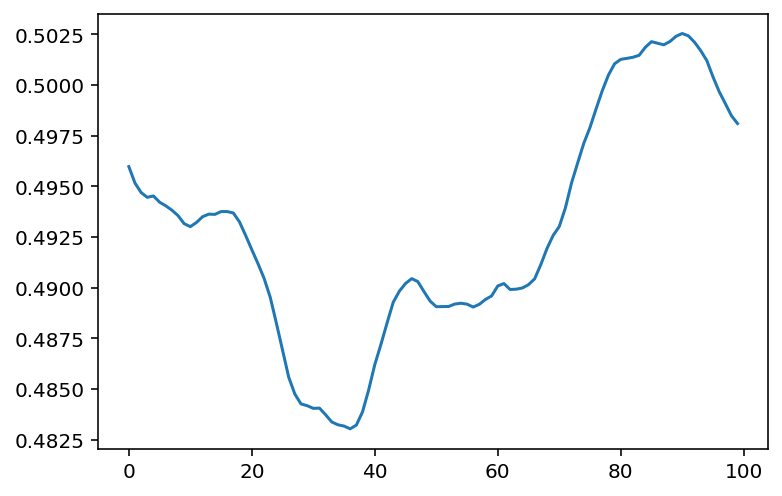

In [16]:
sdGroSys.trc.get_atom_pair_distance_series(2, 8).plot()

Similar to cnf files, trc files also provide a `visualize` function. The function will show a 3D video of the trajectory.

In [17]:
# visualize the trajectory
sdGroSys.trc.visualize(sdGroSys.cnf)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And similar to the trc files, tre files also provide a wide selection of analysis tools out of the box.

<AxesSubplot:>

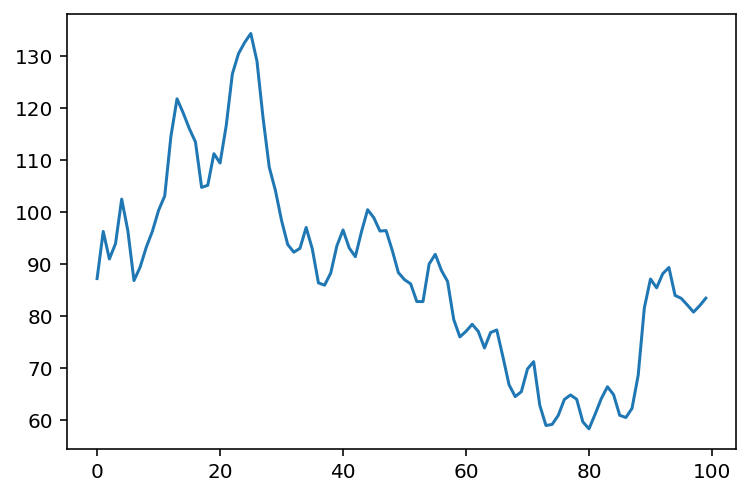

In [18]:
sdGroSys.tre.get_totals_total().plot()

### Non-standard blocks and simple modifications

When devloping with Gromos or experimenting with new features, it can happen that new blocks are defined in `GROMOS`. These blocks are not supported out of the box by `PyGromosTools`. However, `PyGromosTools` is built up highly modular and flexible, which makes it easy to implement extensions. These extensions can be implement at very different levels within the codebase. All classes in `PyGromosTools` that represent files follow a specific structure and offer different implementations to read, write, and, modify the files.  

In the following section, we will have a look at a possible modification to a `IMD` file and the structure of `IMD` files.

In [19]:
test_imd = Imd(template_sd)

`Imd` inherits from `_general_gromos_file` class. While the `_general_gromos_file` class already has default implementations for reading and writing (`read_file` and `to_string`), these are mostly overwritten by the `Imd` class to suit the special needs of IMD files.  

The `Imd` class contains all `IMD` blocks as attributes. These attributes are instances of the `pygromos.files.blocks.imd_blocks` classes. These blocks implement their own read/write functions, which are called from the `Imd` class top down. Every block may have smaller classes for individual fields with their own read/write functions.  

If we look at a simple example of a block like the `SYSTEM` block we can achive a deeper understanding of the underlying structure.

In [20]:
from pygromos.files.blocks.imd_blocks import _generic_imd_block
class testSYSTEM(_generic_imd_block):
    # removed documentation for this example. Original code can be found in pygromos.files.blocks.imd_blocks:145
    name: str = "testSYSTEM"
    # fields
    NPM: int  # number of solute molecules
    NSM: int  # number of solvent molecules

    _order = [[["NPM", "NSM"]]]

    def __init__(self, NPM:int=0, NSM:int=0, content=None):
        super().__init__(used=True, content=content)
        if content is None:
            self.NPM = int(NPM)
            self.NSM = int(NSM)

The `testSYSTEM` class inherits from the `_generic_imd_block` class. In this trivial case we can use the default implementation of all block-specific functions like `read_content_from_str` and `block_to_string` provided by `_generic_imd_block`. These functions are set by the `super()` call in the `__init__` function.  

All we are doing is telling the super class the keys to expect via the `_order` list and the cast of the attributes to the right types. The `_order` attribute always is a three-dimensional list. The inner two dimensions correspond to lines and fields in the block. For example, we could add another field called "test" which we expect to be in the next line by writting:

In [21]:
_order = [[["NPM", "NSM"],["test"]]]

As long as the block does not contain matrices (like `PRESSURESCALE`) the default implementation of read/write functions typically suffices. However, with more complex block structures there might be a need to overload these functions.

Since `_order` is an attribute of the block class, we can easily modify it on the fly. Alternatively, if we are always using a specific order we can simply overwrite the `_order` attribute in the file. This is also a easy way to update `PyGromosTools` to new versions of `GROMOS` blocks.

### New files for new gromos functionality

Sometimes in the process of developing new functionality, new files are added to `GROMOS`. These files might not be supported out of the box by `PyGromosTools`. However, `PyGromosTools` is built up highly modular and flexible, which makes it easy to implement extensions. These extensions can be implement at very different levels within the codebase. All classes in `PyGromosTools` that represent files follow a specific structure and offer different implementations to read, write, and, modify the files.

If a new file is needed a close template can be choosen and often default blocks can bereused. An example would be therecently added QMMM-parameter file support.

In [ ]:
from copy import deepcopy
import warnings

from pygromos.files._basics import _general_gromos_file, parser
from pygromos.files.blocks import qmmm_blocks as blocks



class QMMM_test(_general_gromos_file._general_gromos_file):
    _gromos_file_ending:str = "qmmm"

    _orig_file_path:str
    path:str
    _required_blocks = ["TITLE", "QMZONE", "QMUNIT"]

    # POSSIBLE GROMOS BLOCKS
    TITLE:  blocks.TITLE
    QMZONE: blocks.QMZONE
    QMUNIT: blocks.QMUNIT

    def __init__(self, in_value:str, _future_file:bool=False):
        super().__init__(in_value=in_value, _future_file=_future_file)

    def __str__(self):
        text = ""
        if(hasattr(self, "TITLE")):
            text += self.__getattribute__("TITLE").block_to_string()
        for block in sorted(self.get_block_names()):
            if(block == "TITLE" or isinstance(block, type(None))):
                continue
            text += str(self.__getattribute__(block))
        return text

    def read_file(self):
        #Read blocks to string
        data = parser.read_general_gromos_file(self._orig_file_path)

        #translate the string subblocks
        blocks = {}
        for block_title in data:
            self.add_block(blocktitle=block_title, content=data[block_title])
            blocks.update({block_title: self.__getattribute__(block_title)})
        return blocks

In this short example for a new file we can see, that many default functions of the general file class can be reused. The `__init__()` is simply forwarding it, while `__str__()` is slightly modified. And the `read_file()` function is overwritten but still uses the parser from `general.file._basic`.

This approach has the advantage, that many nice functions and features are inherited from the base classes. For example the ability to access and modify the blocks, but also `copy` functions and the `pickleability` of the class. It makes the design of additional features in gromos simpler and consistent.

## Release 3

### New features

### Current bugs

## Hackathlon

## Final Disscussion